In [30]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as stats
import sys
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from lib.util.helper import query_table, weekday_time_series
import seaborn as sns
import plotly.express as px
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import plotly
import torch
import gpytorch

In [31]:
hauptluftung = weekday_time_series(sensor_id='hauptluftung_30T')

In [32]:
hauptluftung['kw'] = round(hauptluftung['kw'], 2)

In [33]:
px.line(
    x=hauptluftung.index, y=hauptluftung.kw, 
    title='hauptluftung',
    labels={
        'x': 'Time',
        'y': 'kW'
    },
    markers=False)

In [4]:
str(hauptluftung.index.date.max())

'2021-10-15'

In [18]:
day_range = hauptluftung.index.max() - hauptluftung.index.min()
day_range

Timedelta('4 days 23:30:00')

In [62]:
hauptluftung.shape

(240, 9)

In [92]:
time_int_range_30 = np.arange(0, 240*30, 30)
hauptluftung['t'] = time_int_range_30
hauptluftung['t'] = (hauptluftung['t'] - hauptluftung['t'].min()) / (hauptluftung['t'].max() - hauptluftung['t'].min())

#hauptluftung_final = pd.DataFrame(data=hauptluftung['kw'], index=hauptluftung['t'])
#hauptluftung_final.reset_index(inplace=True)

X = hauptluftung['t'].values
y = hauptluftung['kw'].values
n = len(X)
prop_train = 0.8
n_train = round(prop_train * n)

# Training
X_train = torch.from_numpy(X[:n_train]).to(torch.float64)
y_train = torch.from_numpy(y[:n_train]).to(torch.float64)

# Testing
#X_test = torch.from_numpy(y[n_train:]).to(torch.float64)
X_test = torch.from_numpy(X).to(torch.float64)
y_test = torch.from_numpy(y[n_train:]).to(torch.float64)

# Standardizing helps with hyperparameter initialization
y_train_mean = torch.mean(y_train)
y_train_std = torch.std(y_train)

y_train = (y_train - y_train_mean) / (y_train_std)
y_test = (y_test - y_train_mean) / (y_train_std)

#plt.figure(figsize=(16, 6))
#plt.plot(X_train.numpy(), y_train.numpy())
#plt.plot(X_test.numpy(), y_test.numpy())

In [85]:
time_int_range_5 = np.arange(0, 240*5, 5)
hauptluftung['t'] = time_int_range_5

#hauptluftung_final = pd.DataFrame(data=hauptluftung['kw'], index=hauptluftung['t'])
#hauptluftung_final.reset_index(inplace=True)

X = hauptluftung['t'].values
y = hauptluftung['kw'].values
n = len(X)
prop_train = 0.8
n_train = round(prop_train * n)

# Training
X_train = torch.from_numpy(X[:n_train]).to(torch.float64)
y_train = torch.from_numpy(y[:n_train]).to(torch.float64)

# Testing
#X_test = torch.from_numpy(y[n_train:]).to(torch.float64)
X_test = torch.from_numpy(X).to(torch.float64)
y_test = torch.from_numpy(y[n_train:]).to(torch.float64)

# Standardizing helps with hyperparameter initialization
y_train_mean = torch.mean(y_train)
y_train_std = torch.std(y_train)

y_train = (y_train - y_train_mean) / (y_train_std)
y_test = (y_test - y_train_mean) / (y_train_std)

#plt.figure(figsize=(16, 6))
#plt.plot(X_train.numpy(), y_train.numpy())
#plt.plot(X_test.numpy(), y_test.numpy())

In [60]:
time_int_range_1 = np.arange(0, 240*1, 1)

In [61]:
time_int_range_1.shape, time_int_range_5.shape, time_int_range_30.shape

((240,), (240,), (240,))

In [101]:
## new time scale ##

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        ## Locally Periodic Kernel ##
        period_constraint_short = gpytorch.constraints.Interval(15, 25) ## short term

        seasonal_periodic_short = gpytorch.kernels.PeriodicKernel(
            #period_length_constraint=period_constraint_short
        )

        period_constraint_long = gpytorch.constraints.Interval(45, 55) ## long term

        seasonal_periodic_long = gpytorch.kernels.PeriodicKernel(
            #period_length_constraint=period_constraint_long
        )

        ## Local Variations ##
        local_variation_alpha = gpytorch.priors.GammaPrior(2, 0.5)

        local_variation = gpytorch.kernels.RQKernel()
        local_variation.alpha = 1


        self.covar_module = seasonal_periodic_short + seasonal_periodic_long + local_variation
        self.mean_module = gpytorch.means.ZeroMean()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

In [82]:
## best performing ##

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        ## Locally Periodic Kernel ##
        period_constraint_short = gpytorch.constraints.Interval(110, 130) ## short term

        seasonal_periodic_short = gpytorch.kernels.PeriodicKernel(
            period_length_constraint=period_constraint_short
        )

        period_constraint_long = gpytorch.constraints.Interval(225, 245) ## long term

        seasonal_periodic_long = gpytorch.kernels.PeriodicKernel(
            period_length_constraint=period_constraint_long
        )

        ## Local Variations ##
        local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

        local_variation = gpytorch.kernels.RQKernel()
        local_variation.alpha = 1


        self.covar_module = seasonal_periodic_short + seasonal_periodic_long + local_variation
        self.mean_module = gpytorch.means.ZeroMean()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

In [41]:
## v2 - adding scaling parameters ##

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        ## Locally Periodic Kernel ##
        period_constraint_short = gpytorch.constraints.Interval(30, 55) ## short term

        seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_short
                )
            )

        seasonal_rq_short = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RQKernel()
        )

        locally_short_periodic = seasonal_periodic_short + seasonal_rq_short

        period_constraint_long = gpytorch.constraints.Interval(90, 100) ## long term

        seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(
                period_length_constraint=period_constraint_long
                )
            )

        seasonal_rq_long = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RQKernel()
        )

        locally_long_periodic = seasonal_periodic_long + seasonal_rq_long

        ## Local Variations ##
        local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

        local_variation = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RQKernel()
            )
            
        local_variation.alpha = local_variation_alpha


        self.covar_module = locally_short_periodic + locally_long_periodic + local_variation
        self.mean_module = gpytorch.means.ZeroMean()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)

In [102]:
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood=likelihood, model=model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, y_train)
    loss.backward()

    print('Iter {} , Loss = {} , Noise = {}'.format(
        i+1, loss, model.likelihood.noise.item() 
    ))

    optimizer.step()

model.eval()
likelihood.eval()

Iter 1 , Loss = 1.2722857457044165 , Noise = 0.6932471990585327
Iter 2 , Loss = 1.2039563475130162 , Noise = 0.6444966793060303
Iter 3 , Loss = 1.159888739097984 , Noise = 0.5992814898490906
Iter 4 , Loss = 1.1388059970953348 , Noise = 0.5559828281402588
Iter 5 , Loss = 1.1076565197538926 , Noise = 0.514794111251831
Iter 6 , Loss = 1.072965976797058 , Noise = 0.47590869665145874
Iter 7 , Loss = 1.0462852005746133 , Noise = 0.43939879536628723
Iter 8 , Loss = 1.0315753787389224 , Noise = 0.4053550362586975
Iter 9 , Loss = 1.009332173320855 , Noise = 0.3739645183086395
Iter 10 , Loss = 0.9898421451637575 , Noise = 0.34527677297592163
Iter 11 , Loss = 0.9780737146948697 , Noise = 0.3194420337677002
Iter 12 , Loss = 0.9631155886394055 , Noise = 0.29665064811706543
Iter 13 , Loss = 0.9391088884612778 , Noise = 0.2767319977283478
Iter 14 , Loss = 0.9132065183720209 , Noise = 0.2590325176715851
Iter 15 , Loss = 0.8970080152404591 , Noise = 0.24281708896160126
Iter 16 , Loss = 0.86253998005287

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

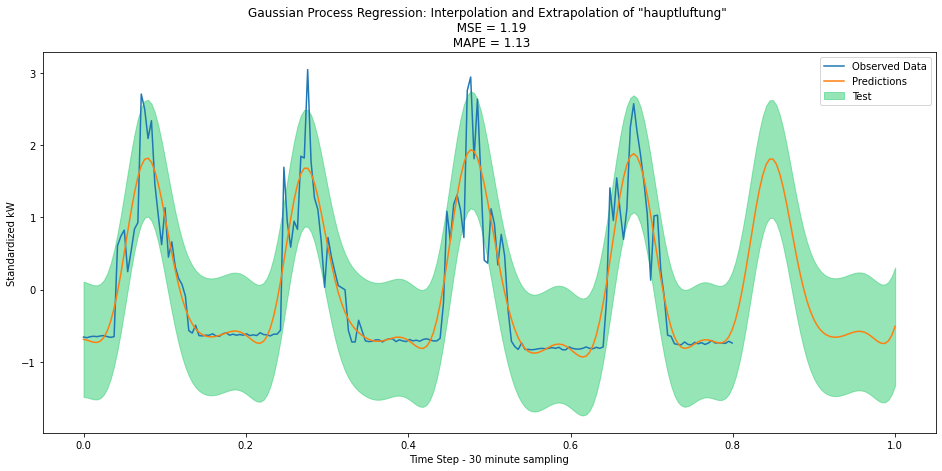

In [103]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_preds = likelihood(model(X_test))

    test_preds = observed_preds.mean[n_train:]
    mse = mean_squared_error(y_test.numpy(), test_preds.numpy())
    mape = mean_absolute_percentage_error(y_test.numpy(), test_preds.numpy())

    f, ax = plt.subplots(figsize=(16, 7))
    lower, upper = observed_preds.confidence_region()
    ax.plot(X_train.numpy(), y_train.numpy())
    ax.plot(X_test.numpy(), observed_preds.mean.numpy())
    ax.fill_between(X_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, color='#2ecc71')
    #plt.axvline(x=955, linestyle='--', color='black', lw=1)
    ax.legend(['Observed Data', 'Predictions', 'Test', 'Uncertainty'])
    plt.xlabel('Time Step - 30 minute sampling')
    plt.ylabel('Standardized kW')
    plt.title('Gaussian Process Regression: Interpolation and Extrapolation of "hauptluftung" \n  MSE = {} \n MAPE = {}'.
    format(round(mse, 2), round(mape, 2)))
    plt.show()

In [33]:
test_preds = observed_preds.mean[n_train:]

In [34]:
mean_squared_error(y_test.numpy(), test_preds.numpy()), mean_absolute_percentage_error(y_test.numpy(), test_preds.numpy())

(0.030756068177624565, 0.18832710048173326)

In [20]:
mean_squared_error(y_test.numpy(), test_preds.numpy()), mean_absolute_percentage_error(y_test.numpy(), test_preds.numpy())

(0.06396455043750866, 0.34132282048023904)

In [84]:
observed_preds.mean

tensor([-1.0525, -1.0758, -1.0828, -1.0557, -1.0317, -1.1038, -1.1305, -1.1661,
        -1.1166, -1.1212, -0.7163, -0.0602,  0.9758,  1.4115,  1.4398,  1.4821,
         1.6107,  1.5701,  1.4718,  1.4287,  1.3509,  1.4321,  1.4662,  1.5265,
         1.5958,  1.2661,  1.0008,  1.2851,  1.2263,  0.9552,  0.8568,  0.6660,
         0.5393,  0.3818, -0.0958, -0.5560, -0.6051, -0.5859, -0.5531, -0.5682,
        -0.5076, -0.6005, -0.5787, -0.6115, -0.5706, -0.6293, -0.6196, -0.5889,
        -0.6061, -0.5790, -0.6193, -0.6603, -0.6402, -0.6744, -0.6911, -0.7004,
        -0.7186, -0.6523, -0.1864,  0.3718,  0.8078,  1.2076,  1.3568,  1.6062,
         1.6398,  1.7889,  1.5025,  1.5290,  1.8210,  1.6469,  1.6172,  1.4301,
         1.3801,  1.3412,  1.1885,  1.4556,  1.3983,  0.8367,  0.3360,  0.0023,
        -0.0848, -0.0934, -0.4312, -0.9077, -0.9453, -0.9875, -0.9310, -0.9767,
        -0.9348, -0.9574, -0.9827, -0.9920, -0.9835, -0.9976, -0.9856, -0.9855,
        -1.0038, -1.0435, -1.1175, -1.11

### Inspection of Learned Hyperparameters

Namely:
 - Lengthscale (wiggliness of the function)
 - Outputscale (if initialized) aka the variance

In [48]:
model.covar_module.lengthscale